<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/inceptionv3/Notebooks/transfer_learning_fine_tunning(voets_partition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import itertools
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
%matplotlib inline

import tensorflow as tf
import keras
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import InceptionV3 
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    GlobalMaxPool1D,
    MaxPooling2D,
    Conv2D,
    BatchNormalization,
    Flatten,
    Dropout,
    Concatenate,
    Activation,
    Bidirectional,
)

from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, model_from_json
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [ ]:
"""
from IPython.display import clear_output
clear_output()
"""

'\nfrom IPython.display import clear_output\nclear_output()\n'

In [ ]:
!gdown https://drive.google.com/uc?id=1kMWRnUaD8VmKwU18mbk3rFZlEi1v7fp6

Downloading...
From: https://drive.google.com/uc?id=1kMWRnUaD8VmKwU18mbk3rFZlEi1v7fp6
To: /content/voets_partition.zip
2.86GB [00:41, 69.5MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1Fij91Xl0KV0d3hx3sDnzqEwoZQGKs21L

Downloading...
From: https://drive.google.com/uc?id=1Fij91Xl0KV0d3hx3sDnzqEwoZQGKs21L
To: /content/messidor2_processed.zip
107MB [00:00, 265MB/s] 


In [ ]:
local_zip = '/content/voets_partition.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
local_zip = '/content/messidor2_processed.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
# Train data 
train_dir_1 = os.path.join('/content/voets_partition/train//1')
train_dir_0 = os.path.join('/content/voets_partition/train//0')

print("Total imagenes training Diabetic Retinopathy:", len(os.listdir(train_dir_1)))
print(
    "Total imagenes training Non Diabetic Retinopathy:",
    len(os.listdir(train_dir_0)),
)

Total imagenes training Diabetic Retinopathy: 10238
Total imagenes training Non Diabetic Retinopathy: 32948


In [ ]:
# Test data 
test_dir_1 = os.path.join('/content/voets_partition/test/1')
test_dir_0 = os.path.join('/content/voets_partition/test/0')

print("Total imagenes Test Diabetic Retinopathy:", len(os.listdir(test_dir_1)))
print(
    "Total imagenes Test Non Diabetic Retinopathy:",
    len(os.listdir(test_dir_0)),
)

Total imagenes Test Diabetic Retinopathy: 2471
Total imagenes Test Non Diabetic Retinopathy: 6515


In [ ]:
dr_files = os.listdir(train_dir_1)
no_dr_files = os.listdir(train_dir_0)

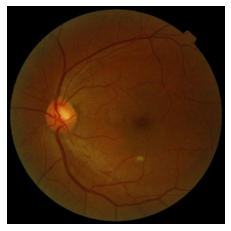

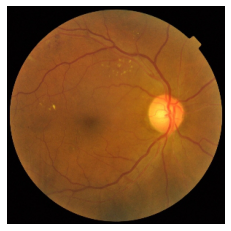

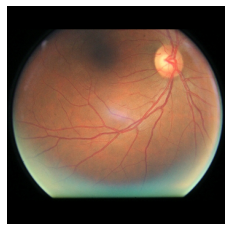

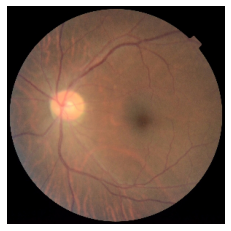

In [ ]:
pic_index = 2

next_dr = [os.path.join(train_dir_1, fname) for fname in dr_files[pic_index - 2 : pic_index]]
next_no_dr = [
    os.path.join(train_dir_0, fname) for fname in no_dr_files[pic_index - 2 : pic_index]
]

for i, img_path in enumerate(next_dr + next_no_dr):

    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis("Off")
    plt.show()

In [ ]:
def preprocessing(image):
    image = tf.image.random_brightness(image, 0.125)
    image = tf.image.random_saturation(image, 0.5, 1.5)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 1.5)
    return image 

In [ ]:
TRAINING_DIR = "/content/voets_partition/train/"
TEST_DIR = "/content/voets_partition/test"
TEST_MESSIDOR_DIR = "/content/messidor2_processed"

BATCH_SIZE = 32
img_width, img_height = 299, 299

datagen = ImageDataGenerator(
    samplewise_center=True,
    horizontal_flip=True,
    rescale=1./255,
    preprocessing_function=preprocessing,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 43186 images belonging to 2 classes.


In [ ]:
train_generator2 = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    class_mode="binary",
    batch_size=1,
    shuffle=False,
)

Found 43186 images belonging to 2 classes.


In [ ]:
test_generator = datagen.flow_from_directory(
	TEST_DIR,
    target_size=(img_width, img_height),
	class_mode='binary', 
    batch_size=1,
    shuffle=False,
)

Found 8986 images belonging to 2 classes.


In [ ]:
messidor_generator = datagen.flow_from_directory(
	TEST_MESSIDOR_DIR,
    target_size=(img_width, img_height),
	class_mode='binary', 
    batch_size=1,
    shuffle=False,
)

Found 1748 images belonging to 2 classes.


In [ ]:
steps_per_epoch = train_generator.n // BATCH_SIZE
#validation_steps = img_iter_dev.n // BATCH_SIZE

In [ ]:
train_generator.n

43186

In [ ]:
BATCH_SIZE

32

In [ ]:
steps_per_epoch

1349

## 1 Fine tunning 

#### Warmup
First we do a warmup training only the top layers:

In [ ]:
base_model = InceptionV3(weights='imagenet', 
                   include_top=False,
                   pooling='avg',
                   input_shape=(img_width, img_height,3))

# Freeze the feature extractor
for layer in base_model.layers:
    layer.trainable=False

x = Dense(2048, activation='relu')(base_model.output)
predictions = Dense(1, activation='sigmoid')(x)

visual_model = Model(inputs=base_model.input, outputs=predictions)

visual_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-6,
                                       decay=4e-5),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

visual_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [ ]:
visual_model.fit_generator(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/5
1349/1349 [==============================] - 395s 293ms/step - loss: 0.5383 - accuracy: 0.7600 - auc_2: 0.5561
Epoch 2/5
1349/1349 [==============================] - 393s 292ms/step - loss: 0.5170 - accuracy: 0.7646 - auc_2: 0.6201
Epoch 3/5
1349/1349 [==============================] - 392s 291ms/step - loss: 0.5074 - accuracy: 0.7692 - auc_2: 0.6448
Epoch 4/5
1349/1349 [==============================] - 393s 291ms/step - loss: 0.5017 - accuracy: 0.7734 - auc_2: 0.6603
Epoch 5/5
1349/1349 [==============================] - 398s 295ms/step - loss: 0.4994 - accuracy: 0.7757 - auc_2: 0.6688


#### Unfreeze the extractor layers:
- Allow some of the layers to train with a reduced learning rate  

In [ ]:
for layer in visual_model.layers:
    layer.trainable = True

# change the learning rate
visual_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-6,
                                       decay=4e-5),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

train_generator.reset()

# train
history = visual_model.fit_generator(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch
    )

Epoch 1/20
1349/1349 [==============================] - 796s 590ms/step - loss: 0.4818 - accuracy: 0.7862 - auc_3: 0.7147
Epoch 2/20
1349/1349 [==============================] - 777s 576ms/step - loss: 0.4615 - accuracy: 0.8006 - auc_3: 0.7356
Epoch 3/20
1349/1349 [==============================] - 771s 572ms/step - loss: 0.4467 - accuracy: 0.8082 - auc_3: 0.7474
Epoch 4/20
1349/1349 [==============================] - 769s 570ms/step - loss: 0.4349 - accuracy: 0.8137 - auc_3: 0.7581
Epoch 5/20
1349/1349 [==============================] - 769s 570ms/step - loss: 0.4255 - accuracy: 0.8184 - auc_3: 0.7662
Epoch 6/20
1349/1349 [==============================] - 769s 570ms/step - loss: 0.4208 - accuracy: 0.8212 - auc_3: 0.7728
Epoch 7/20
1349/1349 [==============================] - 769s 570ms/step - loss: 0.4125 - accuracy: 0.8257 - auc_3: 0.7785
Epoch 8/20
1349/1349 [==============================] - 770s 571ms/step - loss: 0.4078 - accuracy: 0.8293 - auc_3: 0.7834
Epoch 9/20
1349/1349 [==

----------

## 2 Test

#### Metrics on Kaggle train

In [ ]:
train_generator2.reset()
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(train_generator2, 2)
y_true = train_generator2.classes
y_pred_prob_visual = visual_model.predict(train_generator2,verbose=1,workers=0)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
y_pred = (y_pred_prob_visual> threshold).astype('int')

43186/43186 [==============================] - 1271s 29ms/step


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob_visual, pos_label=1)
cm=metrics.confusion_matrix(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
auc = roc_auc_score(y_true, y_pred_prob_visual)
print('AUC: {}'.format(roc_auc_score(y_true, y_pred_prob_visual)))

Accuracy: 0.8530310748853795
AUC: 0.8679948101993011


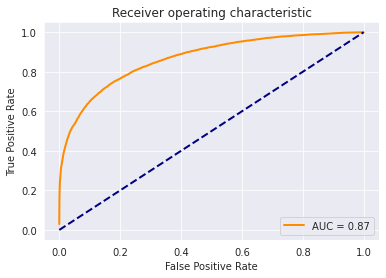

In [ ]:
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax = sns.lineplot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

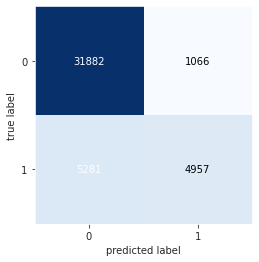

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()

#### Metrics on Kaggle test

In [ ]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(test_generator, 2)
y_true = test_generator.classes

y_pred_prob_visual = visual_model.predict_generator(test_generator, verbose=1, workers=5)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
y_pred = (y_pred_prob_visual> threshold).astype('int')

8986/8986 [==============================] - 253s 28ms/step


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob_visual, pos_label=1)
cm=metrics.confusion_matrix(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
auc = roc_auc_score(y_true, y_pred_prob_visual)
print('AUC: %.3f' % auc)

Accuracy: 0.9134208769196528
AUC: 0.953


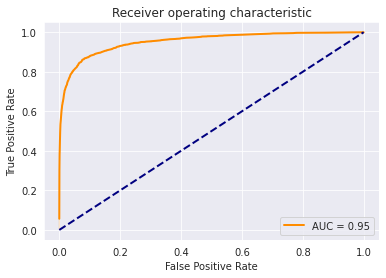

In [ ]:
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax = sns.lineplot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

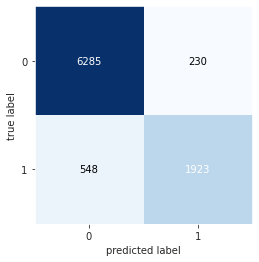

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()

#### Metrics on Messidor-2

In [ ]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(messidor_generator, 2)
y_true = messidor_generator.classes

In [ ]:
y_pred_prob_visual = visual_model.predict_generator(messidor_generator, verbose=1, workers=5)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
y_pred = (y_pred_prob_visual> threshold).astype('int')

1748/1748 [==============================] - 49s 28ms/step


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob_visual, pos_label=1)
cm=metrics.confusion_matrix(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
auc = roc_auc_score(y_true, y_pred_prob_visual)
print('AUC: %.3f' % auc)

Accuracy: 0.6802059496567505
AUC: 0.701


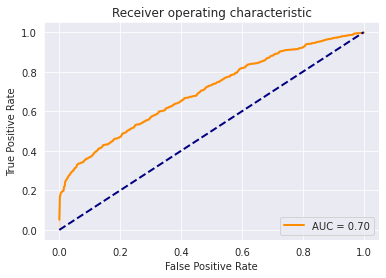

In [ ]:
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax = sns.lineplot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

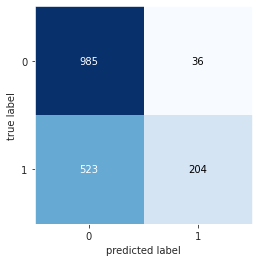

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()